In [1]:
!pip install category_encoders

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.pipeline import make_pipeline,Pipeline
import category_encoders

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split,cross_validate, KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.compose import ColumnTransformer

%matplotlib inline

### Постановка задачи и описание данных:

Описание переменных и датасет взяты с сайта: http://archive.ics.uci.edu/ml/datasets/thyroid+disease

Этот набор данных содержит информацию о заболевании - Гипотиреоз. 

Болезнь характеризуется сниженим функции щитовидной железы, что выражается в недостатой выработке гормонов.
Данные собраны Garvan Institue в Австралии.

Объекты поделены на 5 классов, 29 атрибутов (22 категориальных и 7 численных).


Сами данные описаны следующим образом:
- age:				continuous.
- sex:				M, F.
- on thyroxine:			f, t.
- query on thyroxine:		f, t.
- on antithyroid medication:	f, t.
- sick:				f, t.
- pregnant:			f, t.
- thyroid surgery:		f, t.
- I131 treatment:			f, t.
- query hypothyroid:		f, t.
- query hyperthyroid:		f, t.
- lithium:			f, t.
- goitre:				f, t.
- tumor:				f, t.
- hypopituitary:			f, t.
- psych:				f, t.
- TSH measured:			f, t.
- TSH:				continuous.
- T3 measured:			f, t.
- T3:				continuous.
- TT4 measured:			f, t.
- TT4:				continuous.
- T4U measured:			f, t.
- T4U:				continuous.
- FTI measured:			f, t.
- FTI:				continuous.
- TBG measured:			f, t.
- TBG:				continuous.
- referral_source WEST, STMW, SVHC, SVI, SVHD, other.
- class


Целевая переменная - Class.

### EDA.

Загрузим датасет.

В описании сказано, что данные, которые содержат знак '?' - это пропущенные значения, поэтому сразу укажем это при считывании данных.

Исходно это сформулировано так: several missing attribute values (signified by "?").

In [3]:
df = pd.read_csv('data/dataset_57_hypothyroid.csv', sep = ',',na_values = '?',decimal=".")

In [4]:
df.shape

(3772, 30)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null float64
sex                          3622 non-null object
on_thyroxine                 3772 non-null object
query_on_thyroxine           3772 non-null object
on_antithyroid_medication    3772 non-null object
sick                         3772 non-null object
pregnant                     3772 non-null object
thyroid_surgery              3772 non-null object
I131_treatment               3772 non-null object
query_hypothyroid            3772 non-null object
query_hyperthyroid           3772 non-null object
lithium                      3772 non-null object
goitre                       3772 non-null object
tumor                        3772 non-null object
hypopituitary                3772 non-null object
psych                        3772 non-null object
TSH_measured                 3772 non-null object
TSH                          3403 non-null

In [6]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [7]:
df.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
3767,30.0,F,f,f,f,f,f,f,f,f,...,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,...,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,...,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,...,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative
3771,64.0,F,f,f,f,f,f,f,f,f,...,t,99.0,t,1.07,t,92.0,f,NaN,other,negative


Также посмотрим какие значения содержит целевая переменная:

In [8]:
df.Class.unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

Итого: есть набор данных из 30 колонов и 3772 строк, различных типов.
Наш датасет содержит в себе сразу трейн/тест выборки:  2800 instances in each data set, 972 instances in each test set.

Часть данных - это бинарные признаки (true/false, male/female), другая часть - это численные значения, а также еще есть  referral_source (WEST, STMW, SVHC, SVI, SVHD, other).

Целевая переменная Class состоит из следующих значений: ('negative', 'compensated_hypothyroid', 'primary_hypothyroid',
'secondary_hypothyroid')

Перед тем, как приступать к каким-либо преобразованиям требуется убедиться, в каких объемах есть пропуски и остались ли значения помеченные знаком '?':

Первым делом, проверим, что знаки ? пропали из набора данных.

In [9]:
df.eq('?').sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH_measured                 0
TSH                          0
T3_measured                  0
T3                           0
TT4_measured                 0
TT4                          0
T4U_measured                 0
T4U                          0
FTI_measured                 0
FTI                          0
TBG_measured                 0
TBG                          0
referral_source              0
Class                        0
dtype: int64

Таких значений не оказалось, поэтому идём далее.

Проверим, какая часть данных отсутствует, для этого выведем долю и количество пропущенных значений:

In [10]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                                  0     1
age                        0.000265     1
sex                        0.039767   150
on_thyroxine               0.000000     0
query_on_thyroxine         0.000000     0
on_antithyroid_medication  0.000000     0
sick                       0.000000     0
pregnant                   0.000000     0
thyroid_surgery            0.000000     0
I131_treatment             0.000000     0
query_hypothyroid          0.000000     0
query_hyperthyroid         0.000000     0
lithium                    0.000000     0
goitre                     0.000000     0
tumor                      0.000000     0
hypopituitary              0.000000     0
psych                      0.000000     0
TSH_measured               0.000000     0
TSH                        0.097826   369
T3_measured                0.000000     0
T3                         0.203871   769
TT4_measured               0.000000     0
TT4                        0.061241   231
T4U_measured               0.00000

Столбец TBG состоит из пропусков полностью, поэтому его придется дропнуть.

В остальных столбцах процент пропусков не превышает 20%, что достаточно неплохо и с этим нужно работать.

Удалим TBG, т.к. он не содержит значений вообще.

In [11]:
df.drop('TBG',axis=1,inplace=True)

Исследуем величины, в которых содержаться пропуски, для того, чтобы определиться с тем, будем ли мы их заполнять/чем будем заполнять.

In [12]:
col_with_na = df.columns[df.isna().sum() > 0 ]
col_with_na

Index(['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'], dtype='object')

Так как 6 из 7 признаков - численные, то графики в данном случае строить смысла нет, чтобы не дублировать вывод одной и той же информации. Численные признаки будут рассматриваться далее.

#Глядя на графики сложно предположить, каким значением лучше заполнить пропуски.

Поэтому, для построения baseline выберем среднее для заполнения, а затем попробуем при помощи кросс-валидации, подобрать такой Imputer, который дает наилучший результат.

Для полов построим отдельно гистограмму. В целом, для анализа пропусков этот график не имеет смысла (т.к отствует только 1 значение), но посмотреть на это соотношение стоит, т.к. его можно будет попробовать использовать для дальнейшего анализа при работе с признаками.

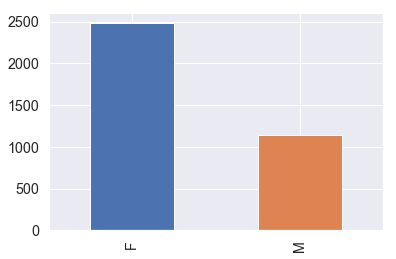

In [13]:
df['sex'].value_counts().plot(kind='bar')

Как оказалось, женщин в выборке в два раза больше, что говорит о дисбалансе в этом признаке.

Зафиксируем целевую переменную а также, выделим числовые и категориальные признаки в отдельные наборы данных.

In [14]:
target = 'Class'
seed = 10
df_num = df.select_dtypes(include=['float64'])
df_cat = df.select_dtypes(include=['object'])

Приступим к анализу численных признаков.

Выведем численные статистики.

In [15]:
df_num.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


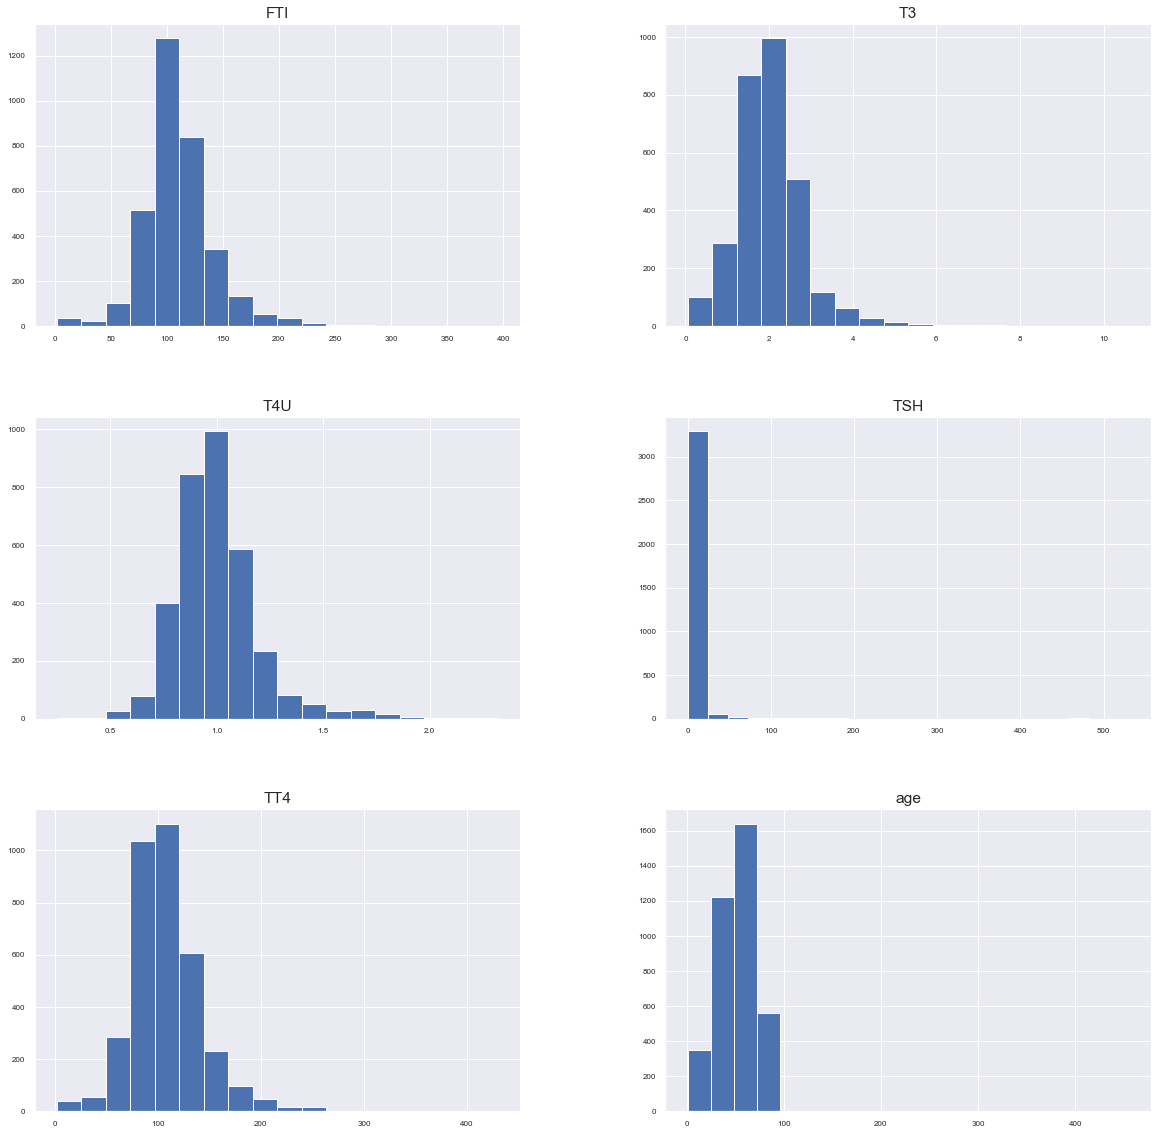

In [16]:
df_num.hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

In [17]:
#ДОБАВИТЬ БОКСПЛОТЫ!

Вывод: 

Скорее всего выбросы есть в: 
- Age , т.к. не может быть возраст 495 (возможно такое и бывает, но из моего опыта, такое невозможно)
- TSH, TT4, FTI т.к.  максимальные значения этих величин выше 75 процентов данных. - эти величины обозначают количество гормонов в крови.

Удалим выброс в Age, т.к. скорее всего это ошибка ввода.

Можно конечно предположить, что человек хотел ввести, 45.5 или 55 и заменить на выбранное число, но так делать некорректно, по отношению к данным.

Проверим значение данного выброса:

In [18]:
print (df_num[df_num.age > 100])
print(df_cat[df_cat.index == 1364])

        age  TSH   T3    TT4   T4U    FTI
1364  455.0  1.1  2.0  118.0  1.13  104.0
     sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
1364   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  \
1364        f               f              f                 f   

     query_hyperthyroid    ...    hypopituitary psych TSH_measured  \
1364                  f    ...                f     f            t   

     T3_measured TT4_measured T4U_measured FTI_measured TBG_measured  \
1364           t            t            t            t            f   

     referral_source     Class  
1364             SVI  negative  

[1 rows x 23 columns]


In [19]:
df_num.drop(index=1364, inplace=True)
df_cat.drop(index=1364, inplace=True)
#сразу обновим индексы
df_num.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

E:\Python\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Рассмотрим величину TSH.

In [20]:
ind_tsh = df_num[df_num.TSH > 300].index
df_num[df_num.TSH > 300]

,age,TSH,T3,TT4,T4U,FTI
1165,18.0,478.0,NaN,45.0,1.30,34.0
2506,2.0,472.0,1.7,34.0,1.17,29.0
2771,25.0,468.0,0.7,21.0,1.10,19.0
3426,18.0,440.0,0.5,24.0,1.32,18.0
3448,59.0,530.0,2.0,10.0,1.12,8.5
3638,60.0,400.0,0.5,11.0,1.19,9.1


In [21]:
df_cat.iloc[ind_tsh,:]

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
1165,F,t,f,f,f,f,f,f,f,f,...,f,f,t,f,t,t,t,f,other,primary_hypothyroid
2506,NaN,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,STMW,primary_hypothyroid
2771,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3426,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3448,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid
3638,F,t,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,primary_hypothyroid


Это не является выбросом, такой вывод сделан из анализа предметной области, высокий уровень TSG говорит об ослабленной щитовидной железе, что подтверждается значением переменной класс.

FTI и TT4 будем рассматривать совместно, т.к. они взаимосвязаны.

In [22]:
ind_TT4_FTI = df_num[(df_num.TT4 > 250) & (df_num.FTI > 250)].index
df_num.iloc[ind_TT4_FTI,:]

,age,TSH,T3,TT4,T4U,FTI
604,27.0,0.020,5.3,272.0,0.97,281.0
743,41.0,0.150,7.3,430.0,1.09,395.0
1414,41.0,0.200,NaN,430.0,1.09,395.0
2994,58.0,0.200,NaN,256.0,0.90,283.0
3257,59.0,0.025,5.7,372.0,1.27,291.0


In [23]:
df_cat.iloc[ind_TT4_FTI,:]

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
604,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,negative
743,F,f,f,f,f,f,f,f,f,t,...,f,f,t,t,t,t,t,f,STMW,negative
1414,F,f,f,f,f,t,f,f,f,t,...,f,f,t,f,t,t,t,f,STMW,negative
2994,F,f,f,f,f,f,f,f,t,t,...,f,f,t,f,t,t,t,f,other,negative
3257,F,t,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,SVHD,negative


Исходя из предметной области, эти величины TT4 и FTI связаны между собой, the Free Thyroxine Index (FTI or T7) is obtained by multiplying the total T4 with T3 uptake.

В нашем случае T3 не uptake, но зависимость прослеживается.

Рассмотрим корреляции между численными величинами:

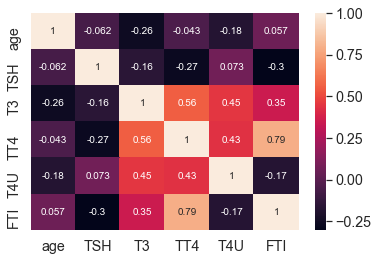

In [24]:
corr = df_num.corr()
sns.heatmap(corr, annot=True);

Выделяются две корреляции:
- T3 и TT4
- TT4 и FTI

Возможно, если мы оставим только TT4 (уберем T3 и FTI), это поможет улучшить обучающую способность модели.
Это проверю при работе с фичами.
Кстати, исходня из анализа предметной области: FTI = Thyroxine (T4)/Thyroid Binding Capacity

Посмотрим на категориальные признаки.

In [25]:
df_cat.describe()

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,...,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,TBG_measured,referral_source,Class
count,3621,3771,3771,3771,3771,3771,3771,3771,3771,3771,...,3771,3771,3771,3771,3771,3771,3771,3771,3771,3771
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,1,5,4
top,F,f,f,f,f,f,f,f,f,f,...,f,f,t,t,t,t,t,f,other,negative
freq,2479,3307,3721,3728,3624,3718,3718,3712,3537,3534,...,3770,3587,3402,3002,3540,3384,3386,3771,2201,3480


In [26]:
for i, col in enumerate(df_cat.columns[:-1]):
    print(df_cat[col].value_counts())

F    2479
M    1142
Name: sex, dtype: int64
f    3307
t     464
Name: on_thyroxine, dtype: int64
f    3721
t      50
Name: query_on_thyroxine, dtype: int64
f    3728
t      43
Name: on_antithyroid_medication, dtype: int64
f    3624
t     147
Name: sick, dtype: int64
f    3718
t      53
Name: pregnant, dtype: int64
f    3718
t      53
Name: thyroid_surgery, dtype: int64
f    3712
t      59
Name: I131_treatment, dtype: int64
f    3537
t     234
Name: query_hypothyroid, dtype: int64
f    3534
t     237
Name: query_hyperthyroid, dtype: int64
f    3753
t      18
Name: lithium, dtype: int64
f    3737
t      34
Name: goitre, dtype: int64
f    3675
t      96
Name: tumor, dtype: int64
f    3770
t       1
Name: hypopituitary, dtype: int64
f    3587
t     184
Name: psych, dtype: int64
t    3402
f     369
Name: TSH_measured, dtype: int64
t    3002
f     769
Name: T3_measured, dtype: int64
t    3540
f     231
Name: TT4_measured, dtype: int64
t    3384
f     387
Name: T4U_measured, dtype: int64
t   

Продублируем таблицу графически:

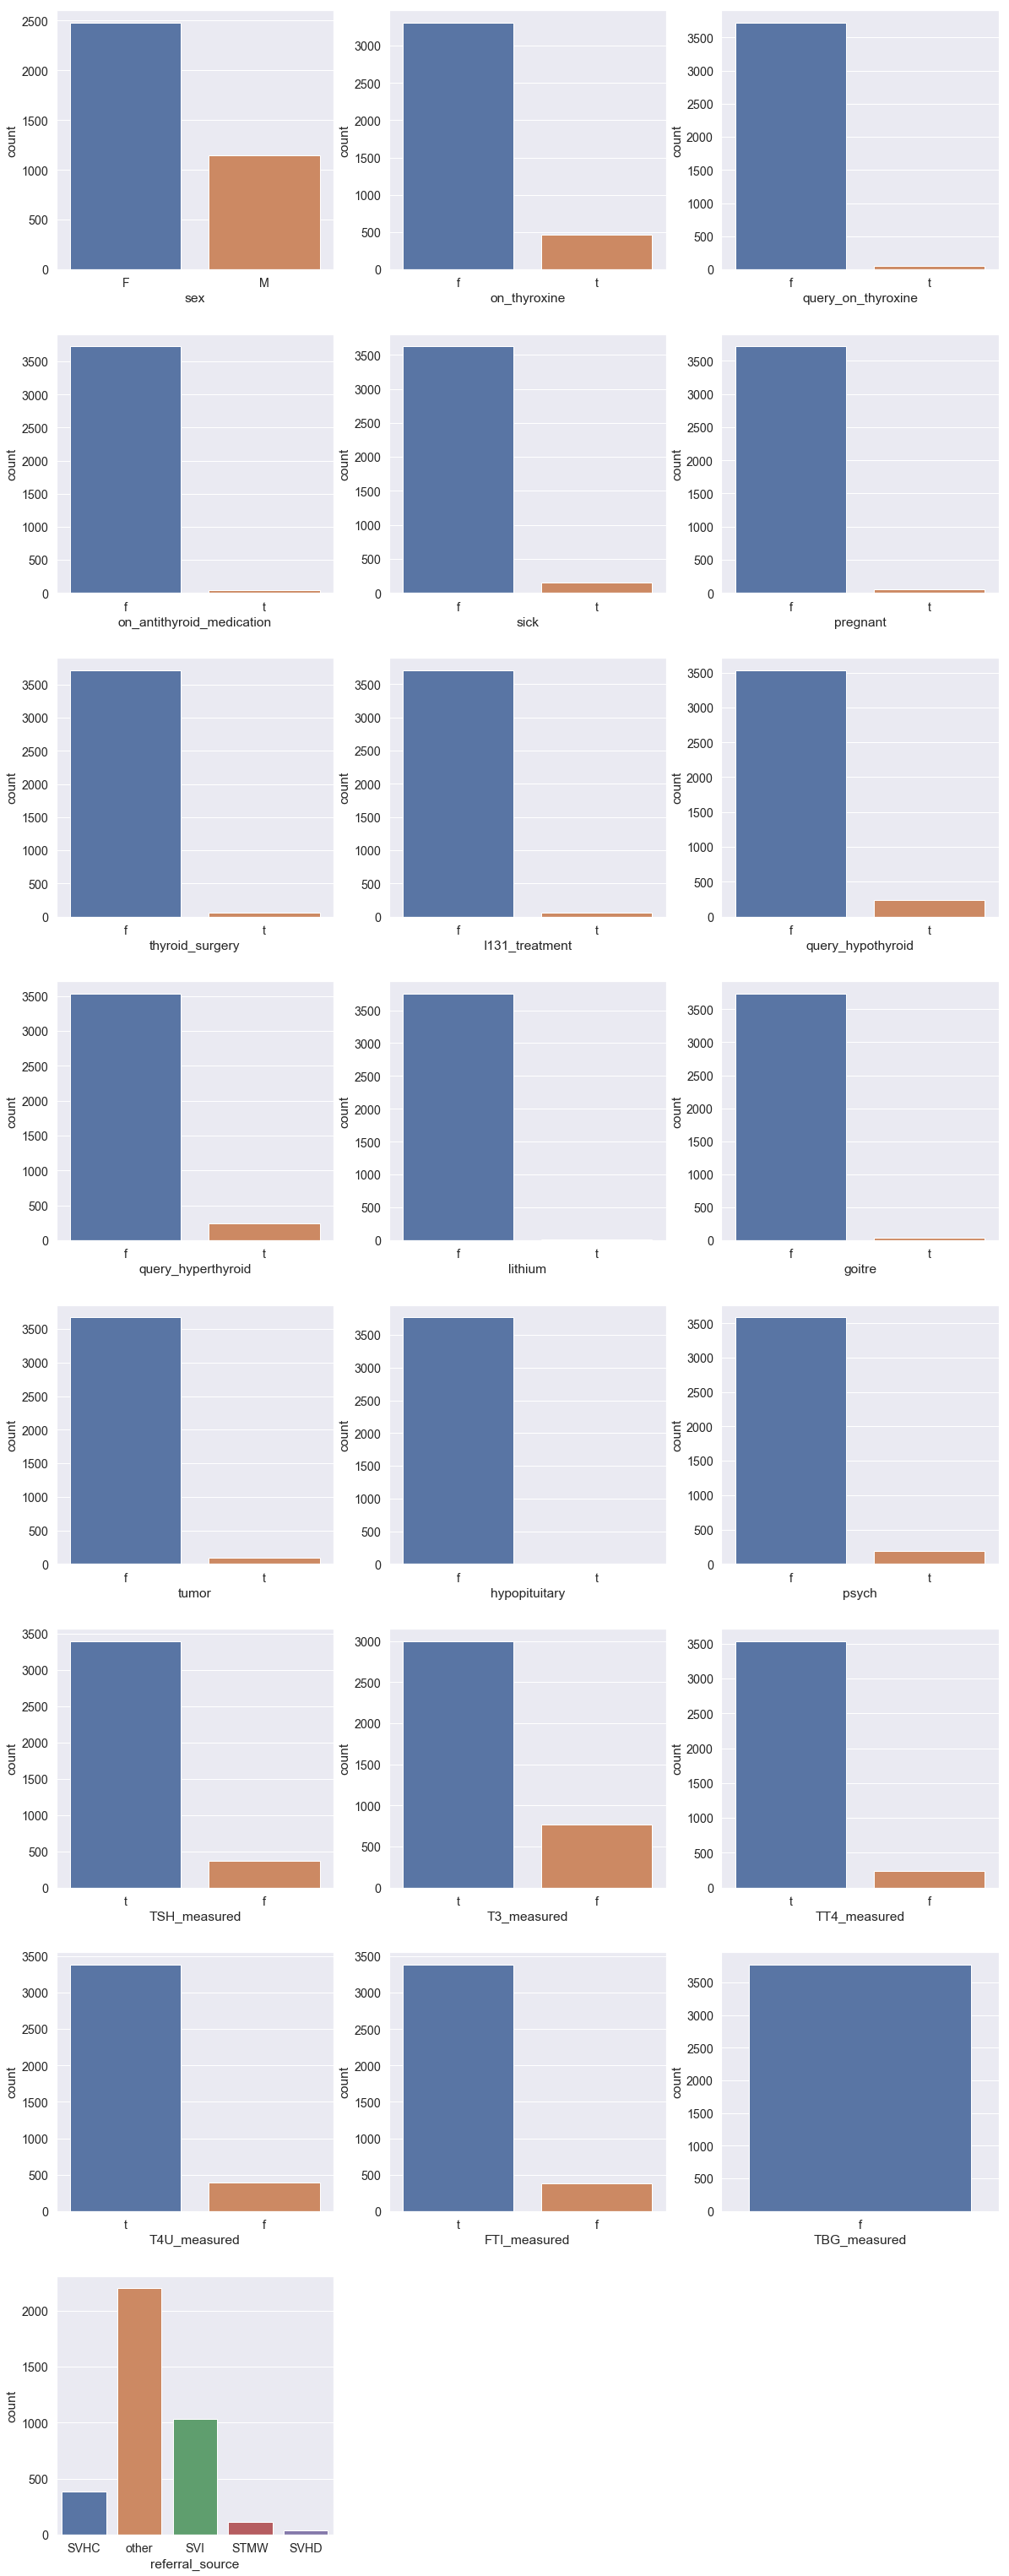

In [27]:
plt.figure(figsize=(20, 55)) 
for i, col in enumerate(df_cat.columns[:-1]):# выводим все величины, кроме последней (целевой, ее будем рассматривать отдельно)
    plt.subplot(8,3,i+1)
    sns.countplot(x=df_cat[col], data=df_cat)
    plt.subplots_adjust(hspace = 0.25)

Из графиков и таблицы можно сделать следующий вывод: 
- большинство классов несбалансированно.
- TBG_measured можно будет дропнуть, т.к. состоить только из одного значения.

In [28]:
df_cat.drop('TBG_measured', axis = 1, inplace=True)

E:\Python\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Анализ целевой переменной.

In [29]:
df_cat[target].value_counts()

negative                   3480
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

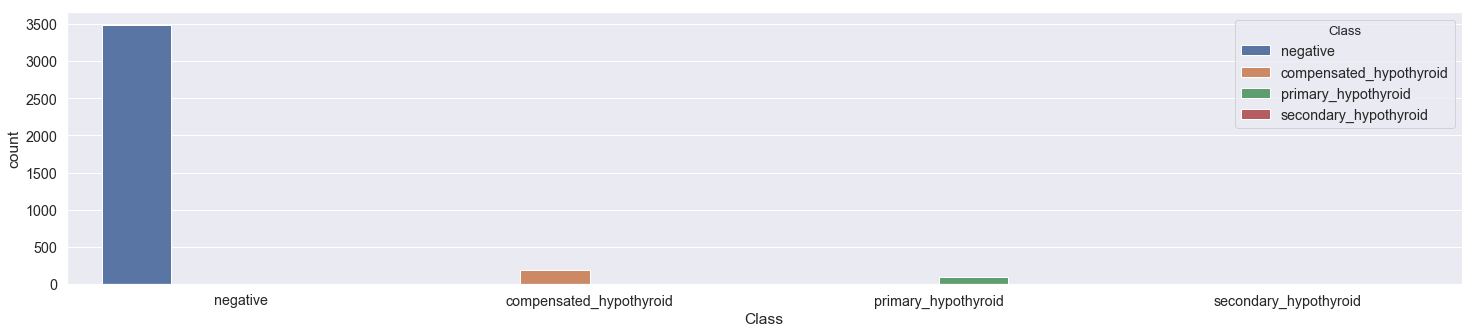

In [30]:
plt.figure(figsize=(25, 5))
sns.countplot(x=df_cat[target], hue='Class', data=df_cat)
plt.show()

Между классам достаточно большой разброс, на качество классификации это скорее всего отрицательно повлияет.

Посмотрим на зависимость других переменных от нашей целевой!

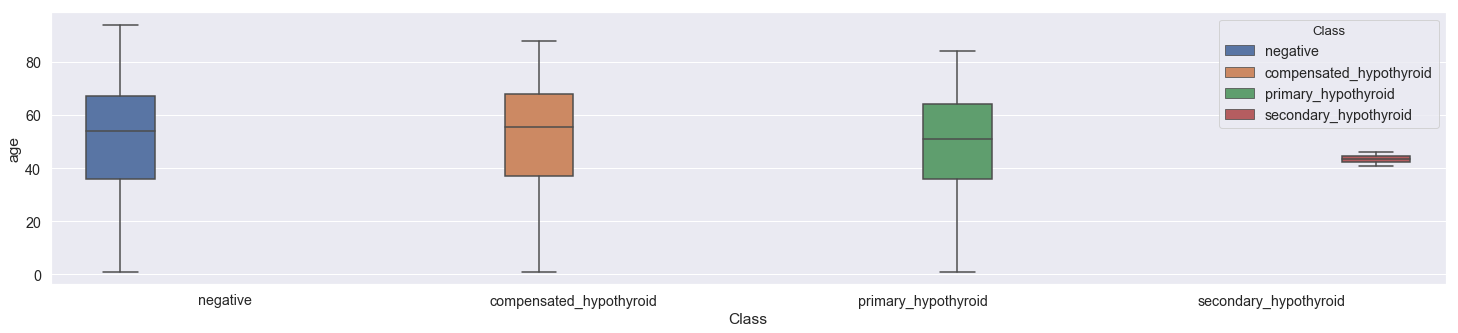

In [31]:
plt.figure(figsize=(25, 5))
sns.boxplot(x=df_cat[target],y=df_num.age, hue='Class', data=df_cat)
plt.show()

Разделим данные, включим стратификацию, потому, что классы несбалансированы.

In [32]:
y = df_cat[target]
X = pd.concat([df_num,df_cat.drop(target, axis=1)], axis=1, sort=False)

In [33]:
# Binarize the output
y = label_binarize(y, classes=['negative', 'compensated_hypothyroid', 'primary_hypothyroid', 'secondary_hypothyroid'])
n_classes = y.shape[1]

"""y = y.replace({'negative': 0, 
                     'compensated_hypothyroid': 1, 
                     'primary_hypothyroid' : 2, 
                     'secondary_hypothyroid' : 3}
                   )"""

"y = y.replace({'negative': 0, \n                     'compensated_hypothyroid': 1, \n                     'primary_hypothyroid' : 2, \n                     'secondary_hypothyroid' : 3}\n                   )"

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=seed, shuffle=True, stratify = y)

In [35]:
X_train.shape

(2639, 27)

In [36]:
X_test.shape

(1132, 27)

In [37]:
y_train.shape

(2639, 4)

In [38]:
y_test.shape

(1132, 4)

Настроим Pipeline для обработки данных и построения baseline-модели.

In [39]:
num_features = list(df_num).copy()
cat_ext = ['referral_source']
cat_bin = list(df_cat).copy()
cat_bin.remove('referral_source')
cat_bin.remove(target)

In [40]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

In [41]:
cat_ext_features_pipeline = Pipeline([
    #('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')), 
    # здесь imputer не требуется т.к. пропусков нет в этой величине
    ('onehot', category_encoders.OneHotEncoder(drop_invariant=True,handle_unknown="ignore"))
])

In [42]:
cat_bin_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', category_encoders.BinaryEncoder(drop_invariant=True,handle_unknown="ignore"))
])

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, num_features),
        ('cat_ext', cat_ext_features_pipeline, cat_ext),
        ('cat_bin', cat_bin_features_pipeline, cat_bin)
    ]
)

In [44]:
clf_log = OneVsRestClassifier(LogisticRegression(multi_class = 'ovr',
                                                 solver='newton-cg',
                                                 random_state = seed,
                                                 n_jobs = -1,
                                                 max_iter = 10e4))

In [45]:
baseline_pipeline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log)
    ]
)

In [46]:
logit_regr = baseline_pipeline_logit.fit(X_train, y_train)

Посчитаем метрики для этого baseline'a.

In [50]:
y_pred = logit_regr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1045
           1       0.61      0.38      0.47        58
           2       0.86      0.89      0.88        28
           3       0.00      0.00      0.00         1

   micro avg       0.97      0.96      0.97      1132
   macro avg       0.62      0.57      0.58      1132
weighted avg       0.97      0.96      0.96      1132
 samples avg       0.95      0.96      0.95      1132



E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


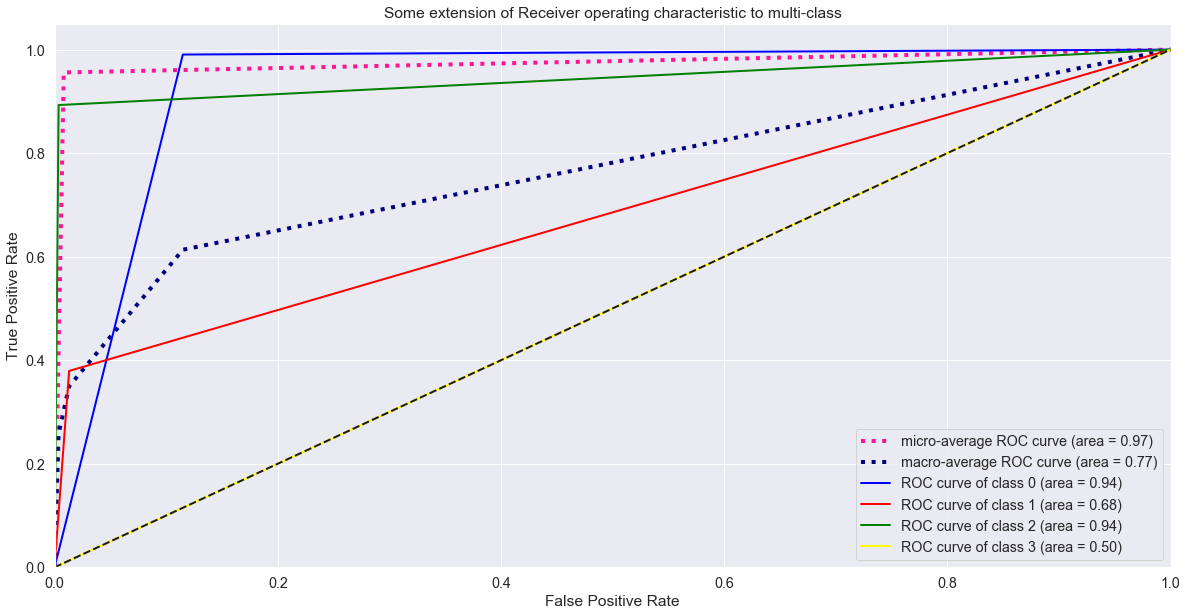

In [51]:
from scipy import interp
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'green','yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Вывод.


Попробуем повторить тоже самое для KNN.

In [61]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
baseline_pipeline_knn = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_knn)
    ]
)

In [62]:
knn = baseline_pipeline_knn.fit(X_train, y_train)

In [63]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1045
           1       0.66      0.40      0.49        58
           2       0.83      0.71      0.77        28
           3       0.00      0.00      0.00         1

   micro avg       0.96      0.95      0.95      1132
   macro avg       0.61      0.52      0.56      1132
weighted avg       0.95      0.95      0.95      1132
 samples avg       0.95      0.95      0.95      1132



E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Python\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
n_classes

In [ ]:
y

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from sklearn.tree import DecisionTreeClassifier


iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=0))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
lw = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred = all_features_transformed_logit.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred[:,0])
#all_features_transformed_logit.steps[1][1].coef_

In [ ]:
"""clfs = []
clfs.append(LogisticRegression())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs
baseline_pipeline.set_params(clf = classifier)"""

In [ ]:
print test